# Meteograma

En este ejemplo se describe hacer una figura que muestra la evolución de la temperatura a 2 m y la precipitación horaria en todos los plazos del pronóstico para una latitud y longitud.

In [1]:
import xarray as xr
import h5netcdf
import datetime
import s3fs
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

Se define la fecha de inicialización del pronóstico y la latitud y longitud a consultar.

In [15]:
latitud = -40
longitud = -50

año_ini = 2022
mes_ini = 3
dia_ini = 21
hora_ini = 0

Se leen los pronósticos 

In [ ]:
FECHA_INI = datetime.datetime(año_ini, mes_ini, dia_ini, hora_ini)

fs = s3fs.S3FileSystem(anon=True)

files = fs.glob(f'smn-ar-wrf/DATA/WRF/DET/{FECHA_INI:%Y/%m/%d/%H}/WRFDETAR_01H_{FECHA_INI:%Y%m%d_%H}_*.nc')

ds_list = []
for s3_file in files:
    print(s3_file)
    f = fs.open(s3_file)
    ds_tmp = xr.open_dataset(f, decode_coords = 'all', engine = 'h5netcdf')
    ds_list.append(ds_tmp)

ds = xr.combine_by_coords(ds_list, combine_attrs = 'drop_conflicts')

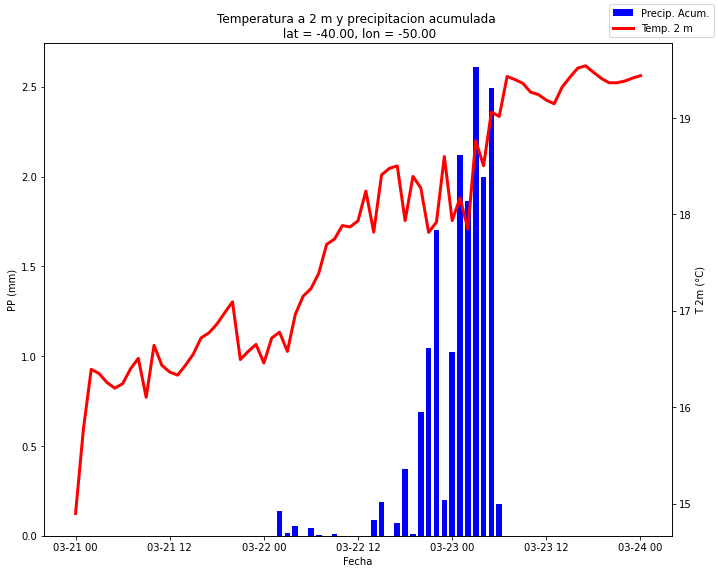

In [16]:
#Se busca la ubicacion del punto mas cercano a la latitud y longitud solicitada
data_crs = ccrs.LambertConformal(central_longitude = ds.CEN_LON, 
                                 central_latitude = ds.CEN_LAT, 
                                 standard_parallels = (ds.TRUELAT1, ds.TRUELAT2))
x, y = data_crs.transform_point(longitud, latitud, src_crs=ccrs.PlateCarree())

#Selecciono el dato mas cercano a la latitud, longitud
pronostico = ds.sel(dict(x = x, y = y), method = 'nearest')

#Obtengo la serie de temperatura a 2 m, precipitacion acumulada y de fechas
T2 = pronostico['T2']
PP = pronostico['PP']
fechas = pronostico['time']

#Inicio la figura
fig, ax = plt.subplots(figsize = (10, 8))
#Duplico el eje x
ax2 = ax.twinx()
#Grafico la precipitacion en barras
ax.bar(fechas, PP, color = 'blue', width = 0.03, label = 'Precip. Acum.')
#Grafico la tempertura con una linea
ax2.plot(fechas, T2, color = 'red', label = 'Temp. 2 m', linewidth = 3)
#Defino las etiquetas de los ejes
ax.set_xlabel('Fecha')
ax2.set_ylabel('T 2m (°C)')
ax.set_ylabel('PP (mm)')
#Defino el titulo de la figura
plt.title(f'Temperatura a 2 m y precipitacion acumulada \n lat = {latitud:0.2f}, lon = {longitud:0.2f}')
#Grafico la leyenda
fig.legend(loc = 'upper right')
#Ajusto el grafico al tamaño de la figura
plt.tight_layout()